In [1]:
import time
import pandas as pd
from pyspark.sql import SparkSession
from operator import add
import os
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import length
from pyspark.sql.functions import regexp_replace, lower
from pyspark.sql.functions import avg, max
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StringIndexer
import pandas as pd
import numpy as np

In [2]:
spark_session = SparkSession.builder\
.appName("yufengchen_app")\
.config("spark.dynamicAllocation.enabled", True)\
.config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
.config("spark.shuffle.service.enabled", True)\
.config("spark.dynamicAllocation.executorIdleTimeout","30s")\
.config("spark.cores.max", 8)\
.config("spark.executor.memory", "16g") \
.config("spark.driver.memory", "16g") \
.getOrCreate()

spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")


file_path = '/home/ubuntu/preprocessed_data/RC_2011-08/part-00000-c10c1768-58ca-4301-b700-3650017b2f6b-c000.json'

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/05 18:33:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read the json
reddit_comments_df = spark_session.read.json(file_path).select('author', 'link_id', 'score')

In [4]:
author_indexer = StringIndexer(inputCol="author", outputCol="user_id")
reddit_comments_df = author_indexer.fit(reddit_comments_df).transform(reddit_comments_df)

In [5]:
link_indexer = StringIndexer(inputCol="link_id", outputCol="item_id")
reddit_comments_df = link_indexer.fit(reddit_comments_df).transform(reddit_comments_df)

In [6]:
(training_data, test_data) = reddit_comments_df.randomSplit([0.2, 0.8])

In [7]:
# ALS model
als = ALS(userCol="user_id", itemCol="item_id", ratingCol="score", nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")
model = als.fit(training_data)

In [12]:
# predict
predictions = model.transform(test_data)

In [14]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="score", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 34.11057100366963


In [17]:
predicted_scores = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

In [18]:
actual_scores = predictions.select("score").rdd.flatMap(lambda x: x).collect()

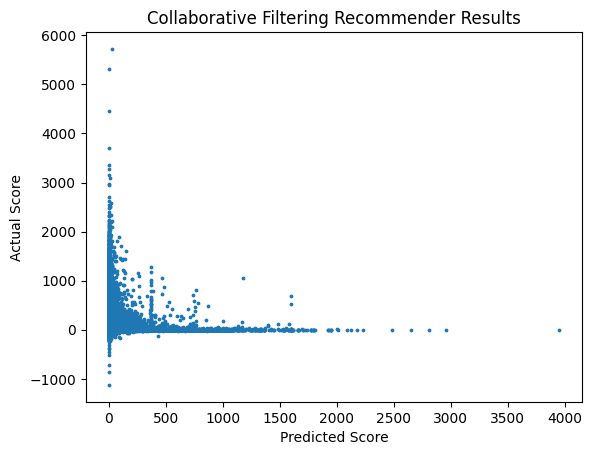

In [22]:
plt.scatter(predicted_scores, actual_scores, s=3)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Collaborative Filtering Recommender Results")
plt.show()

In [26]:
# spark.stop()